# Topic 1 B -  Logistic Regression vs Logistic Regression + PCA (Pipeline)

This notebook corresponds to the Lecture 1 scripts:

- `log_reg_ex1.py` (Logistic Regression baseline)
- `log_reg_pca_ex2.py` (Logistic Regression + PCA)

We use a **synthetic classification dataset** with redundant features to see **when PCA can help**.

---

## Learning goals

In this notebook the **goal** is to understand:

1. What **redundant / correlated features** are (and why they can be annoying).
2. What cross-validation is measuring and why we use **Stratified** CV for classification.
3. Why PCA must be inside a **Pipeline** to avoid leakage.
4. How to explore **accuracy vs number of components (k)**.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

## 1) Create a dataset with redundant features

We generate a binary classification dataset with:

- `n_features=20` total features
- `n_informative=10` features actually contain signal about the target
- `n_redundant=10` features are *linear combinations* of the informative ones (highly correlated)

Why this matters:
- Redundant features often create **multicollinearity** (features tell you the same thing).
- Some models become less stable or harder to optimize.
- PCA can compress redundant information into fewer directions.


In [3]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=10,
    random_state=7
)

print("X shape:", X.shape)
print("Class counts:", np.bincount(y))

display(pd.DataFrame(X).head())
display(pd.DataFrame(y).head())

X shape: (1000, 20)
Class counts: [505 495]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.080548,0.822733,-1.211753,2.421184,3.304243,-6.343576,-0.369886,0.064277,0.094521,-4.364430,-2.943058,0.502341,-2.339147,0.153031,0.543728,-0.420523,1.456127,2.882609,1.791600,-4.297088
1,-2.330300,-4.866086,-3.882913,-2.232483,1.445153,2.597391,3.689269,-1.651189,-2.478660,-1.719449,1.739934,-3.885896,-1.440399,3.128698,-5.370488,3.881865,0.759844,-0.145616,-0.554894,0.614208
2,-1.197150,1.555631,-0.618716,7.193674,-3.300375,-0.033224,4.182462,0.290963,0.886022,-0.685233,2.631218,1.015341,2.441568,0.932073,-1.899996,-3.049732,-3.174851,1.734818,0.130674,-3.133515
3,1.535769,-0.733499,0.204541,0.907992,-1.142800,-2.342064,2.533897,-1.140052,4.231472,0.032415,0.610521,2.093248,-2.800467,-2.093340,1.102820,1.385990,-0.476395,3.055135,1.764456,-1.132424
4,1.947908,3.409123,3.574408,-4.579258,3.181229,-2.982798,-3.618861,1.490834,3.125231,-1.153063,-2.563104,0.668844,-3.032168,-2.448262,2.317296,5.087334,1.568465,-0.429839,1.992009,2.669929


,0
0,0
1,0
2,0
3,1
4,0


## 2) Baseline model: Logistic Regression on raw features

### What Logistic Regression does
Logistic Regression is a **linear classifier**:
- it computes a weighted sum of features
- then passes it through a sigmoid to output a probability
- decision boundary is linear in the original feature space

Here we evaluate with **Repeated Stratified K-Fold**:
- **Stratified**: keeps class proportions similar in each fold
- **Repeated**: repeats CV multiple times with different splits, giving a more stable estimate


### Logistic Regression: the core idea (with a bit of math)

For each sample \(x\) (a vector of features), Logistic Regression computes a **score**:

$$
z = w^T x + b
$$

- \(x\) = feature vector (your input row)
- \(w\) = learned weights (one weight per feature)
- \(b\) = bias/intercept

Then it turns that score into a probability using the **sigmoid**:

$$
\hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Finally, it predicts a class using a threshold (often 0.5):
- if $\hat{p} \ge 0.5$ → class 1
- else → class 0

✅ **Why it’s called “logistic”**: it uses the *logistic (sigmoid)* function to map any real number to \([0, 1]\).


### What does “linear classifier” mean here?

Even though we output a probability, the **decision boundary** is linear.

The boundary is where $\hat{p} = 0.5$.
That happens when $z = 0$, i.e.:

$$
w^T x + b = 0
$$

So Logistic Regression separates the space with a **hyperplane**:
- in 2D → a line
- in 3D → a plane
- in 20D → a hyperplane

✅ So: probabilities are nonlinear, but the separation surface is still **linear in the original features**.


### Interpreting the CV result: mean accuracy ± std

The output looks like:

`LogReg (raw) accuracy: 0.824 (0.034)`

Meaning:
- **0.824** = average accuracy across all CV folds (and repeats)
- **0.034** = standard deviation across those scores  
  → how much performance fluctuates depending on which data ends up in train vs validation

✅ Lower std → more stable estimate  
✅ Higher std → performance depends more on the split


### Why Repeated *Stratified* K-Fold?

We use it because:

#### Stratified
Each fold keeps **roughly the same class proportions** as the full dataset.
This matters when classes are imbalanced (otherwise one fold might get too many 0s or 1s).

#### Repeated
Regular K-Fold gives one estimate based on one split strategy.
Repeating CV with different random splits gives a more **reliable** estimate.


### Why redundancy can matter (and why PCA might help next)

This dataset has **redundant features**: extra columns that are combinations of informative ones.

For Logistic Regression, redundancy can:
- make weights less stable (many weight combinations can work similarly)
- increase multicollinearity (features overlap heavily)
- sometimes make optimization harder / noisier

PCA can help by compressing correlated features into a smaller set of **uncorrelated components**.
But PCA is unsupervised → it may also drop useful signal, so we test it properly with CV.


In [4]:
model = LogisticRegression(max_iter=1000)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_raw = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

print("LogReg (raw) accuracy: %.3f (%.3f)" % (scores_raw.mean(), scores_raw.std()))

LogReg (raw) accuracy: 0.824 (0.034)


In [5]:
# Extra inspection: what is being averaged?

print("Number of CV scores:", len(scores_raw))
print("First 10 scores:", np.round(scores_raw[:10], 3))

print("\nSummary:")
print("  Mean accuracy:", round(scores_raw.mean(), 4))
print("  Std accuracy :", round(scores_raw.std(), 4))
print("  Min accuracy :", round(scores_raw.min(), 4))
print("  Max accuracy :", round(scores_raw.max(), 4))
print("  Range        :", round(scores_raw.max() - scores_raw.min(), 4))

Number of CV scores: 30
First 10 scores: [0.81 0.83 0.83 0.77 0.79 0.85 0.85 0.83 0.88 0.81]

Summary:
  Mean accuracy: 0.8243
  Std accuracy : 0.0338
  Min accuracy : 0.77
  Max accuracy : 0.92
  Range        : 0.15


## 3) PCA + Logistic Regression (Pipeline)

### Why use a Pipeline?
If you run PCA before cross-validation, PCA would “see” the entire dataset (including validation folds).
That is **data leakage** and can inflate performance.

A `Pipeline` ensures that **inside each CV fold**:
1) scaling (optional but good practice)
2) PCA fit happens only on the training part
3) the classifier is trained on the transformed training data
4) validation data is transformed using the training PCA parameters

### Why include StandardScaler here?
PCA is variance-based, so scaling is usually recommended unless you are sure all features are comparable.
With synthetic data it often won’t change much, but it’s the safe habit.


In [9]:
pipe_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10)),
    ("model", LogisticRegression(max_iter=1000))
])

scores_pca10 = cross_val_score(pipe_pca10, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

print("LogReg + StandardScaler + PCA(10) accuracy: %.3f (%.3f)" % (scores_pca10.mean(), scores_pca10.std()))
print("Delta (PCA10 - raw): %.4f" % (scores_pca10.mean() - scores_raw.mean()))

LogReg + StandardScaler + PCA(10) accuracy: 0.825 (0.034)
Delta (PCA10 - raw): 0.0010


## 4) How much variance do 10 PCs capture?

Even though this is a *classification* problem, it’s useful to check how much variance PCA keeps.

We fit scaler + PCA on the full X **only for inspection** (not for evaluation).


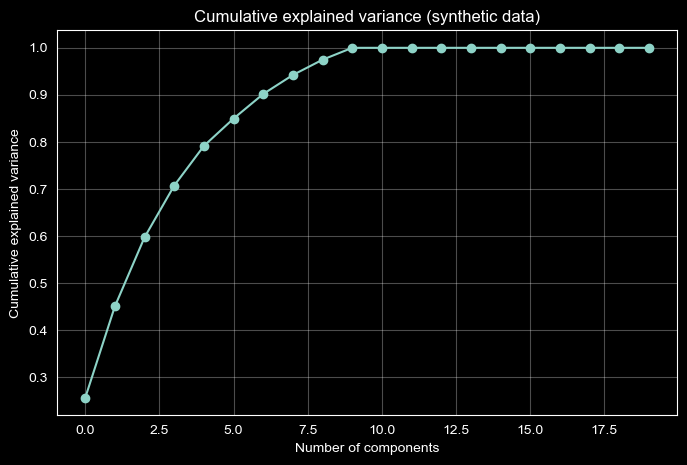

Components for >=90% variance: 7
Components for >=95% variance: 9


In [10]:
# Fit scaler + PCA just for inspection (not model evaluation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_all = PCA().fit(X_scaled)
cum = np.cumsum(pca_all.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cum, marker="o")
plt.title("Cumulative explained variance (synthetic data)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True, alpha=0.3)
plt.show()

k90 = np.argmax(cum >= 0.90) + 1
k95 = np.argmax(cum >= 0.95) + 1
print("Components for >=90% variance:", k90)
print("Components for >=95% variance:", k95)

## 5) Explore: accuracy vs number of components (k)

Now we sweep different values of `n_components` and see how accuracy changes.

What to look for:
- Small k may drop too much information → accuracy drops
- Medium k may remove redundancy/noise → accuracy improves
- Very large k approaches the raw feature space → accuracy returns to baseline


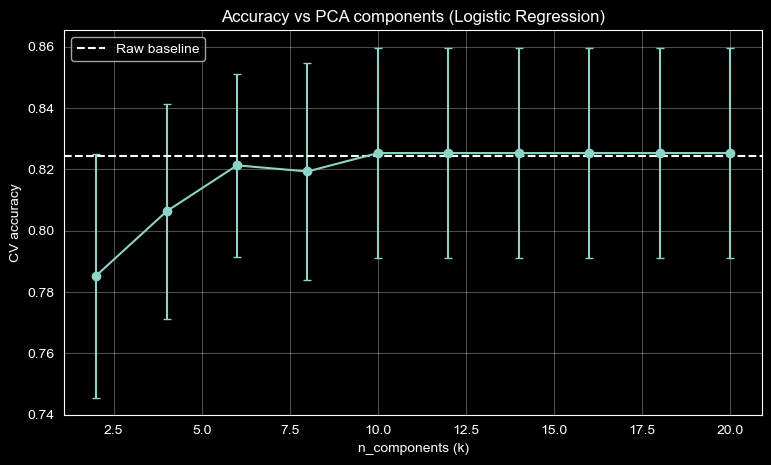

Best k: 10
Best mean accuracy: 0.8253
Baseline mean accuracy: 0.8243


In [11]:
ks = list(range(2, 21, 2))
means, stds = [], []

for k in ks:
    pipe_k = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k)),
        ("model", LogisticRegression(max_iter=1000))
    ])
    s = cross_val_score(pipe_k, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    means.append(s.mean())
    stds.append(s.std())

plt.figure(figsize=(9, 5))
plt.errorbar(ks, means, yerr=stds, marker="o", capsize=3)
plt.axhline(scores_raw.mean(), linestyle="--", label="Raw baseline")
plt.xlabel("n_components (k)")
plt.ylabel("CV accuracy")
plt.title("Accuracy vs PCA components (Logistic Regression)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

best_idx = int(np.argmax(means))
print("Best k:", ks[best_idx])
print("Best mean accuracy:", round(means[best_idx], 4))
print("Baseline mean accuracy:", round(scores_raw.mean(), 4))

## 6) Short interpretation guid

- If PCA improves accuracy (even slightly), it often means:
  - redundancy was hurting (multicollinearity / noise)
  - PCA kept the “signal directions” and dropped some useless variation

- If PCA hurts accuracy:
  - the dropped directions contained signal useful for classification
  - or the problem needs the original feature space

Remember:
- PCA is **unsupervised** → it preserves variance, not “predictiveness”
- The best k is task-dependent → use validation/CV to choose it


------

### ✅ Interpretation of results (Baseline vs PCA + Logistic Regression)

#### 1) Baseline (raw Logistic Regression)
- **Mean CV accuracy:** 0.8243
- **Std (across folds):** 0.0338
- **Min / Max:** 0.77 / 0.92 (range = 0.15)
- **# of CV scores:** 30 (10 folds × 3 repeats)

**Meaning:** performance is ~82.4% on average, with noticeable variation depending on the split (std ≈ 3.4 percentage points).

---

#### 2) PCA + Logistic Regression (Pipeline)
- **Mean CV accuracy:** 0.8253
- **Std:** 0.034
- **Delta vs baseline:** **+0.0010** (≈ +0.10 percentage points)

✅ **Key conclusion:** PCA(10) gives a *tiny* improvement, but it is **much smaller than the CV variability** (std ≈ 0.034).
So this is best interpreted as: **PCA performs about the same as the baseline** for this dataset.

---

#### 3) Accuracy vs number of components (k)
- **Best k (in the sweep):** 10
- **Best mean accuracy:** 0.8253
- **Baseline mean accuracy:** 0.8243

Observed pattern (from the plot):
- small k (too few PCs) → accuracy drops (too much information removed)
- medium k (around 8–10 PCs) → recovers baseline and slightly improves
- large k → stays near baseline (approaching the original space)

✅ **Interpretation:** a moderate number of components is enough to represent most of the useful structure, while too aggressive compression loses signal.

---

#### 4) Variance context (how much PCA is keeping)
- **k for ≥90% variance:** 7
- **k for ≥95% variance:** 9

This supports why PCA(10) works well:
- most variance is already captured by ~7–9 components
- using 10 components keeps almost all variance while still compressing redundancy

---

#### 5) Why PCA didn’t change accuracy much here (the “why”)
- Logistic Regression is already a strong baseline for *linear* problems.
- PCA is **unsupervised**: it preserves variance, not “predictiveness”, so improvements are not guaranteed.
- Redundant features exist, but they may not be hurting LogReg enough to see a big gain.

---

#### Exam-ready summary (2 lines)
- **Baseline LogReg:** 0.8243 ± 0.0338
- **PCA(10) + LogReg:** 0.8253 ± 0.034 → essentially **no meaningful improvement** (delta is tiny vs CV variability), but PCA achieves similar performance with fewer effective dimensions.
